# The story of Lucia de Berk

---

  
> which was the case of a miscarriage of justice in the Netherlands in 2003, 
    in which a Dutch licensed paediatric nurse was wrongfully convicted of murder, at large based on “statistical evidence”.  
    One of the various pieces of evidence against de Berk in the original trial were the testimony of a statistician (Elffers), who said that the odds that it was a coincidence that all the incidents occurred when she was on duty were 342 million to one.  
    Doubts were raised about de Berk’s conviction when this claim was criticised, much later. 
    In December 2009, with new statistical analysis and medical evidence having been presented, the court accepted that the had all been entirely natural.  
    There were many problems in the original data collection and analysis, conducted by Elffers, see, e.g., Meester et al. (2006 )Gill et al. (2018); Green et al. (2022); O’Grady (2023). 
    One of these problems was not taking into account an important causal factor (morning/evening+night shifts) that was correlated with both the types of shifts that Lucia de Berk did mostly and the increased rate of incidences in mornings.  
    Your will conduct simulations, where you will generate count data, similar to the data analyzed in Lucia de Berk’s case, and compare 3 types of analyses. Conduct 200 replications of the following process:  


**Generation of data.** Set the total number of shifts to `1029`, where a third of  
them correspond to the morning shifts, and all the rest to evening/night shifts.  
Denote the binary indicator of the morning shift by morning.   
Given morning = `1`  
generate a binary indicator Lucia of whether Lucia was on duty from `Bern(0.4)`,  
otherwise from `Bern(0.1)`.  
If you aggregate these two indicators into a 2-by-2 table, you will get something  
similar to:  
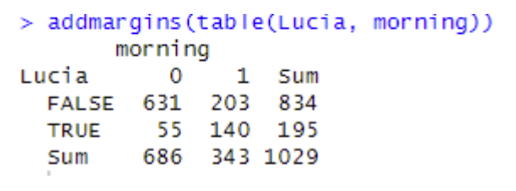

You will get different numbers, but of the same order of magnitude.  



In [1]:
import numpy as np
import pandas as pd
shifts = 1_029
mornings_part = 1/3
is_morning, is_not_morning = 1, 0
morning = np.random.choice([0, 1], size=shifts, p=[2/3, 1/3])
lucia = np.where(
    morning == 1,
    np.random.binomial(n=1, p=0.4, size=shifts),
    np.random.binomial(n=1, p=0.1, size=shifts)
).astype(bool)
df = pd.DataFrame({"Lucia": lucia, "morning": morning})
# Note: crosstab just to display and compare to image
pd.crosstab(df['Lucia'], df['morning'], margins=True, margins_name="Sum")


morning,0,1,Sum
Lucia,,,
False,609,207,816
True,65,148,213
Sum,674,355,1029


Now, generate the number of incidences (deaths) occurred for each of the combi-  
nations of Lucia and morning, from the following Poisson regression model with a log link and an offset for the number of shifts

$$
log \big( \frac{\mu (x_1, x_2)}{t(x_1, x_2)} \big) = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

Where $X_1$ = _morning_, $X_2$=_Lucia_ $t(x_1, x_2)$ equals the number of shifts corre-  
sponding to $(x_1, x_2)$ and,  with $\beta_0 = -4, \beta_1 = 1.7, \beta_2 = 0$.

Notice that if we marginalize our data with respect to morning, the data will look
like a 2-by-2 table, similar to the original data from the Lucia de Berk trial, but
with different counts. Here are the original data:  

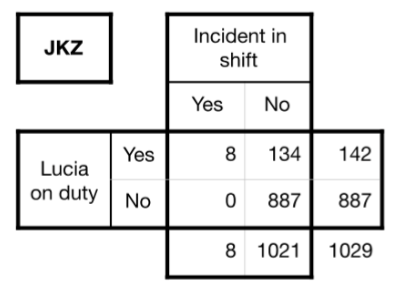


And here are, for example, the aggregated over morning simulated data  
obtained in one of the replications:  

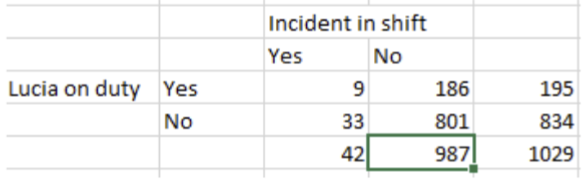

In [2]:
beta_0, beta_1, beta_2 = -4.0, 1.7, 0.0

# -1- Agg Shifts
cell_counts = df.groupby(["morning", "Lucia"]).size().rename("shift_count").reset_index()
# shift_count = t(x_1,x_2) = the number of shifts (morning, Lucia)
 
cell_counts

,morning,Lucia,shift_count
0,0,False,609
1,0,True,65
2,1,False,207
3,1,True,148


We want to find $\mu (x_1, x_2) = $ Expected number of deaths
$$
log \big( \frac{\mu (x_1, x_2)}{t(x_1, x_2)} \big) = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$
$$
\implies \frac{\mu (x_1, x_2)}{t(x_1, x_2)} = e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2}
$$
$$
\implies \mu (x_1, x_2) = e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2}\cdot t(x_1, x_2)
$$

In [3]:
cell_counts["mu"] = cell_counts["shift_count"] * np.exp(
    beta_0 + beta_1 * cell_counts["morning"]
) # mu(x_1,x_2)
cell_counts

,morning,Lucia,shift_count,mu
0,0,False,609,11.154224
1,0,True,65,1.190517
2,1,False,207,20.753581
3,1,True,148,14.838309


Now apply the poission to the mu

In [4]:
cell_counts["deaths"] = np.random.poisson(cell_counts["mu"])
cell_counts

,morning,Lucia,shift_count,mu,deaths
0,0,False,609,11.154224,10
1,0,True,65,1.190517,1
2,1,False,207,20.753581,11
3,1,True,148,14.838309,14


In [10]:
lucia_marginal = (
    cell_counts
    .groupby("Lucia", as_index=False)
    .agg(
        deaths=("deaths", "sum"),
        shifts=("shift_count", "sum")
    )
)
lucia_marginal


,Lucia,deaths,shifts
0,False,21,816
1,True,15,213


Sanity check

In [12]:

# helper to pull row by Lucia indicator
lucia_yes = lucia_marginal.loc[lucia_marginal["Lucia"] == 1].iloc[0]
lucia_no  = lucia_marginal.loc[lucia_marginal["Lucia"] == 0].iloc[0]

incident_yes_lucia  = int(lucia_yes["deaths"])
incident_no_lucia   = int(lucia_yes["shifts"] - lucia_yes["deaths"])

incident_yes_not    = int(lucia_no["deaths"])
incident_no_not     = int(lucia_no["shifts"] - lucia_no["deaths"])

table = pd.DataFrame(
    {
        "Incident in shift: Yes": [incident_yes_lucia, incident_yes_not],
        "Incident in shift: No":  [incident_no_lucia,  incident_no_not],
    },
    index=["Lucia on duty: Yes", "Lucia on duty: No"],
)

# add row & column totals like in the figure
table.loc["Total"] = table.sum(axis=0)
table["Total"] = table.sum(axis=1)

table

,Incident in shift: Yes,Incident in shift: No,Total
Lucia on duty: Yes,15,198,213
Lucia on duty: No,21,795,816
Total,36,993,1029


(b) **Careful analysis**. Analyze the obtained count data using the Poisson log-linear
regression with an intercept and 2 factors $X1 = morning$ and $X2 = Lucia$, and
include an offset term to account for the different number of shifts between Lucia
de Berk and the rest of the nurses. Keep the pvalue corresponding to the effect of
$X_2$.

In [14]:
cell_counts

,morning,Lucia,shift_count,mu,deaths,log_shift
0,0,False,609,11.154224,10,6.411818
1,0,True,65,1.190517,1,4.174387
2,1,False,207,20.753581,11,5.332719
3,1,True,148,14.838309,14,4.997212
